# Getting the Labels Ready

To look for:

* **CHOOSE requires action** 

* CONSTRUCT
* CHECK
* SAVE

## Imports

In [1]:
%matplotlib inline
from pycocotools.coco import COCO

import json
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
# https://stackoverflow.com/questions/18035595/powersets-in-python-using-itertools
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
def reverse_one_to_many_dict(one_to_many_dict):
    one_to_one_dict = {}
    
    for key, arr in one_to_many_dict.items():
        for a in arr:
            assert a not in one_to_one_dict, "Trying to replace existing key: {}".format(a)
            one_to_one_dict[a] = key
            
    return one_to_one_dict


# sample_dict_good = {
#     'a': [1, 2, 3],
#     'b': [4, 5, 6]
# }
# print(reverse_one_to_many_dict(sample_dict_good)) # all good

# sample_dict_bad = {
#     'a': [1, 2, 3],
#     'b': [3, 5, 6]
# }
# print(reverse_one_to_many_dict(sample_dict_bad)) # supposed to fail with 3

## CHOOSE: Images and Annotations Directories

In [4]:
dataDir='..'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir, dataType)

In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


**Note**, `cat` and `cats` stand for **category** and **categories** NOT for cat that is like a dog, but a cat.

In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n\n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n\t{}'.format(' '.join(nms)))

COCO categories: 

person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
	outdoor electronic appliance animal person food sports accessory kitchen furniture indoor vehicle


## CHOOSE: categories of Interest

In [7]:
CATEGORIES_OF_INTEREST = sorted(['person', 'dog', 'cat', 'bird'])
CATEGORIES_OF_INTEREST

['bird', 'cat', 'dog', 'person']

## CONSTRUCT a mapping from the categories of interest to image IDs

In [8]:
%%time

catNms_to_imgIds = {}
for include_cats_names in powerset(CATEGORIES_OF_INTEREST):
    include_cats_names = tuple(sorted(include_cats_names)) # sort to have the same keys every time
    
    # include_cats_names should be a tuple (immutable) so that we can use it as a key to a dictionary
    exclude_cats_names = set(CATEGORIES_OF_INTEREST) - set(include_cats_names)
    exclude_cats_names = tuple(sorted(exclude_cats_names)) # sort to have the same keys every time
    
    catIds = coco.getCatIds(catNms=include_cats_names)
    exclCatIDs = coco.getCatIds(catNms=exclude_cats_names)
    
    imgIds = coco.getImgIds(catIds=catIds, exclCatIds=exclCatIDs)

    catNms_to_imgIds[include_cats_names] = imgIds

# correct the Ids for the images which do not have any of the categories in the CATEGORIES_OF_INTEREST
# correction needed because
#    include_cats_names = () results in
#    catIds = All Coco categories but the CATEGORIES_OF_INTEREST
#    There are no images with all those categories present
catNms_to_imgIds[()] = coco.getImgIds(exclCatIds=coco.getCatIds(CATEGORIES_OF_INTEREST))


# correct the Ids for the images with all of the CATEGORIES_OF_INTEREST present
# correction needed because
#    exclude_cats_names = () results in
#    exclCatIds = All Coco categories but the CATEGORIES_OF_INTEREST
#    We exclude all the images with any of the exclusion categories present, which is likely to exclude all the images
catNms_to_imgIds[tuple(sorted(CATEGORIES_OF_INTEREST))] = coco.getImgIds(catIds=coco.getCatIds(CATEGORIES_OF_INTEREST))

CPU times: user 11 ms, sys: 276 µs, total: 11.3 ms
Wall time: 11.2 ms


## CHECK that the IDs in disjoint sets are a partition of the original set of images

1. $\cup s_i = S$, where $S$ - original set of IDs
2. $ s_i \cap s_j = \emptyset, \forall i \neq j$ - indexes of different categories

### CHECK that the sets created are disjoint

2. $ s_i \cap s_j = \emptyset, \forall i \neq j$ - indexes of different categories

In [9]:
%%time

for key1 in catNms_to_imgIds:
    for key2 in catNms_to_imgIds:
        if key1 == key2:
            pass
        else:
            s1 = set(catNms_to_imgIds[key1])
            s2 = set(catNms_to_imgIds[key2])
            inters = s1.intersection(s2)
            
            # # for debugging
            # print(key1, len(s1))
            # print(key2, len(s2))
            # print('Intersection:', inters, '\n')
            
            assert len(inters) == 0, "The subsets have to be disjoint"

CPU times: user 3.23 ms, sys: 0 ns, total: 3.23 ms
Wall time: 3.24 ms


### Calculate how many images are in each disjoint category

In [10]:
catNms_to_ImgIdsNum = {key: len(value) for (key, value) in catNms_to_imgIds.items()}
catNms_to_ImgIdsNum

{(): 1965,
 ('bird',): 90,
 ('cat',): 147,
 ('dog',): 91,
 ('person',): 2565,
 ('bird', 'cat'): 4,
 ('bird', 'dog'): 0,
 ('bird', 'person'): 31,
 ('cat', 'dog'): 10,
 ('cat', 'person'): 21,
 ('dog', 'person'): 74,
 ('bird', 'cat', 'dog'): 0,
 ('bird', 'cat', 'person'): 0,
 ('bird', 'dog', 'person'): 0,
 ('cat', 'dog', 'person'): 2,
 ('bird', 'cat', 'dog', 'person'): 0}

In [11]:
summary = {
    'category': [],
    'total': []
}
for key in catNms_to_ImgIdsNum:
    summary['category'].append(key)
    summary['total'].append(catNms_to_ImgIdsNum[key])
    
summary_df = pd.DataFrame(summary)


assert summary_df['total'].sum() == len(set(coco.getImgIds())), "Some images were missed"
summary_df

,category,total
0,(),1965
1,"(bird,)",90
2,"(cat,)",147
3,"(dog,)",91
4,"(person,)",2565
5,"(bird, cat)",4
6,"(bird, dog)",0
7,"(bird, person)",31
8,"(cat, dog)",10
9,"(cat, person)",21


### CHECK that the union adds up to the original set

1. $\cup s_i = S$, where $S$ - original set of IDs

In [12]:
all_ids = set(coco.getImgIds())
len(all_ids)

my_all_ids = set().union(*[catNms_to_imgIds[key] for key in catNms_to_imgIds])
len(my_all_ids)


# all ids we have now should be at least the subset of the original ones, uncomment the next line to see it work
# my_all_ids.add(1) 
assert my_all_ids.issubset(all_ids), "Got some new ids that were not present in Coco"


# all ids from the original set have to be contained in the union of the disjoint sets of ids
assert all_ids.issubset(my_all_ids), "We are missing some of the images from the original set"


# which pictures have we missed?
print("IDs missed:", all_ids - my_all_ids)
for sample_id in list(all_ids - my_all_ids):
    print(sample_id)
    
    sample_img_info = coco.loadImgs(sample_id)[0]

    print('Fields available:', list(sample_img_info.keys()), '\n')
    for key, value in sample_img_info.items():
        print(key, (13-len(key))*' ', ':', value)
        
    print('\n', '-'*80, '\n')



IDs missed: set()


### SAVE: `catNms_to_imgIds` in a json file

In [13]:
# can't save .json files with tuples as keys, but can with strings as keys
strCatNms_to_imgIds = {' '.join(key):value for (key, value) in catNms_to_imgIds.items()}

strCatNms_to_ImgIdsNum = {key: len(value) for (key, value) in strCatNms_to_imgIds.items()}
strCatNms_to_ImgIdsNum

{'': 1965,
 'bird': 90,
 'cat': 147,
 'dog': 91,
 'person': 2565,
 'bird cat': 4,
 'bird dog': 0,
 'bird person': 31,
 'cat dog': 10,
 'cat person': 21,
 'dog person': 74,
 'bird cat dog': 0,
 'bird cat person': 0,
 'bird dog person': 0,
 'cat dog person': 2,
 'bird cat dog person': 0}

In [14]:
with open(f'../my_annotations/strCatNms_to_imgIds_{dataType}.json', 'w') as f:
    json.dump(strCatNms_to_imgIds, f, sort_keys=True)

In [15]:
with open(f'../my_annotations/strCatNms_to_imgIds_{dataType}.json', 'r') as f:
    strCatNms_to_imgIds = json.load(f)

In [16]:
strCatNms_to_ImgIdsNum = {key: len(value) for (key, value) in strCatNms_to_imgIds.items()}
strCatNms_to_ImgIdsNum

{'': 1965,
 'bird': 90,
 'bird cat': 4,
 'bird cat dog': 0,
 'bird cat dog person': 0,
 'bird cat person': 0,
 'bird dog': 0,
 'bird dog person': 0,
 'bird person': 31,
 'cat': 147,
 'cat dog': 10,
 'cat dog person': 2,
 'cat person': 21,
 'dog': 91,
 'dog person': 74,
 'person': 2565}

## CONSTRUCT a mapping from Categories to Labels

`catNms_to_labels`

In [17]:
CATEGORIES_OF_INTEREST

['bird', 'cat', 'dog', 'person']

In [18]:
catNms_to_labels = {}

for cat_name in catNms_to_imgIds:
    multilabel = []
    for c in CATEGORIES_OF_INTEREST:
        multilabel.append(int(c in set(cat_name)))
    
    catNms_to_labels[cat_name] = multilabel

catNms_to_labels

{(): [0, 0, 0, 0],
 ('bird',): [1, 0, 0, 0],
 ('cat',): [0, 1, 0, 0],
 ('dog',): [0, 0, 1, 0],
 ('person',): [0, 0, 0, 1],
 ('bird', 'cat'): [1, 1, 0, 0],
 ('bird', 'dog'): [1, 0, 1, 0],
 ('bird', 'person'): [1, 0, 0, 1],
 ('cat', 'dog'): [0, 1, 1, 0],
 ('cat', 'person'): [0, 1, 0, 1],
 ('dog', 'person'): [0, 0, 1, 1],
 ('bird', 'cat', 'dog'): [1, 1, 1, 0],
 ('bird', 'cat', 'person'): [1, 1, 0, 1],
 ('bird', 'dog', 'person'): [1, 0, 1, 1],
 ('cat', 'dog', 'person'): [0, 1, 1, 1],
 ('bird', 'cat', 'dog', 'person'): [1, 1, 1, 1]}

## CONSTRUCT a mapping from Images to Disjoint Categories

`imgIds_to_cats`

In [19]:
imgIds_to_catNms = reverse_one_to_many_dict(catNms_to_imgIds)

# for key in np.random.choice(list(imgIds_to_catNms.keys()), 1000):
#     print(key, imgIds_to_catNms[key])

## CONSTRUCT a mapping from Images to Multi-Labels

`imgIds_to_labels`

In [20]:
imgIds_to_labels = {}

coco.getImgIds()
for imgId in coco.getImgIds():
    catNm = imgIds_to_catNms[imgId]
    imgIds_to_labels[imgId] = catNms_to_labels[catNm]
    
imgIds_to_labels

{397133: [0, 0, 0, 1],
 37777: [0, 0, 0, 0],
 252219: [0, 0, 0, 1],
 87038: [0, 0, 0, 1],
 174482: [0, 0, 0, 0],
 403385: [0, 0, 0, 0],
 6818: [0, 0, 0, 0],
 480985: [0, 0, 0, 1],
 458054: [0, 0, 0, 0],
 331352: [0, 0, 0, 0],
 296649: [1, 0, 0, 1],
 386912: [0, 0, 0, 1],
 502136: [0, 0, 0, 0],
 491497: [0, 0, 0, 0],
 184791: [0, 0, 0, 0],
 348881: [0, 0, 0, 1],
 289393: [1, 0, 0, 0],
 522713: [0, 0, 0, 1],
 181666: [0, 0, 0, 1],
 17627: [0, 0, 0, 1],
 143931: [0, 0, 0, 1],
 303818: [0, 0, 0, 1],
 463730: [0, 0, 0, 1],
 460347: [0, 0, 0, 1],
 322864: [0, 0, 0, 1],
 226111: [0, 0, 0, 0],
 153299: [0, 0, 0, 0],
 308394: [0, 0, 0, 1],
 456496: [1, 0, 0, 1],
 58636: [0, 0, 0, 0],
 41888: [1, 0, 0, 0],
 184321: [0, 0, 0, 0],
 565778: [0, 0, 0, 1],
 297343: [0, 0, 0, 0],
 336587: [0, 0, 0, 0],
 122745: [0, 0, 0, 0],
 219578: [0, 1, 1, 0],
 555705: [0, 1, 0, 0],
 443303: [0, 1, 0, 0],
 500663: [0, 0, 0, 0],
 418281: [0, 0, 0, 0],
 25560: [0, 1, 0, 1],
 403817: [0, 1, 0, 0],
 85329: [0, 0, 0, 1

In [21]:
len(imgIds_to_labels)

5000

### CHECK: that the numbers for generic categories are the same

In [22]:
imgIds_to_labels_df = pd.DataFrame(imgIds_to_labels).T
imgIds_to_labels_df

,0,1,2,3
397133,0,0,0,1
37777,0,0,0,0
252219,0,0,0,1
87038,0,0,0,1
174482,0,0,0,0
...,...,...,...,...
512403,0,0,0,0
168974,0,0,0,1
552775,0,0,0,1
394940,0,0,0,1


In [23]:
for i, name in enumerate(CATEGORIES_OF_INTEREST):
    print(i, name)

0 bird
1 cat
2 dog
3 person


In [24]:
imgIds_to_labels_df.sum(axis=0)

0     125
1     184
2     177
3    2693
dtype: int64

In [25]:
for i, catNm in enumerate(sorted(CATEGORIES_OF_INTEREST)):
    catId = coco.getCatIds(catNms=[catNm])
    imgIds = coco.getImgIds(catIds=catId)
    print(i, len(imgIds))
    
    assert len(imgIds) == imgIds_to_labels_df.sum(axis=0)[i], \
        "Numbers for primary category ({}: '{}') do not match".format(i, CATEGORIES_OF_INTEREST[i])

0 125
1 184
2 177
3 2693


### SAVE: `imgIds_to_labels` in a json file

**Important:** this labels can only be used if the images are resized without cropping. If any cropping is done, some parts of the image will be cropped out and some of the objects can no longer be present in the cropped images.

In [26]:
import json

with open(f'../my_annotations/imgIds_to_labels_{dataType}.json', 'w') as f:
    json.dump(imgIds_to_labels, f, sort_keys=True)

In [27]:
with open(f'../my_annotations/imgIds_to_labels_{dataType}.json', 'r') as f:
    imgIds_to_labels = json.load(f)

## EXTRACT: the segmentation annotation labels (to be used with cropping)

In [28]:
CATEGORIES_OF_INTEREST, coco.getCatIds(catNms=CATEGORIES_OF_INTEREST)
catIDs = coco.getCatIds(catNms=CATEGORIES_OF_INTEREST)

In [29]:
disjoint_cat = np.random.choice(np.array(list(catNms_to_imgIds.keys()), dtype=object))
disjoint_cat

('person',)

In [30]:
sample_img_id = np.random.choice(catNms_to_imgIds[disjoint_cat])
print(sample_img_id, type(sample_img_id)) # does not work when calling coco.loadImgs(sample_img_id)[0]

sample_img_id = int(sample_img_id)
print(sample_img_id, type(sample_img_id))

533145 <class 'numpy.int64'>
533145 <class 'int'>


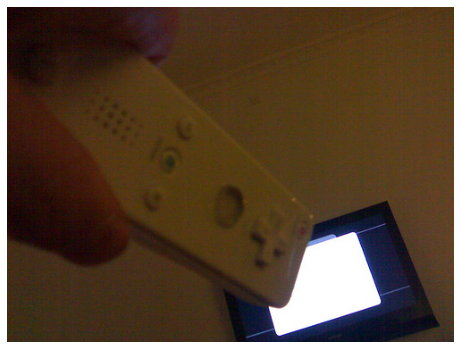

(numpy.ndarray, (375, 500, 3))

In [31]:
sample_img_info = coco.loadImgs(sample_img_id)[0]
sample_img = io.imread(sample_img_info['coco_url'])

plt.axis('off')
plt.imshow(sample_img)
plt.show()

type(sample_img), sample_img.shape

1 objects of selected categories found on this image.


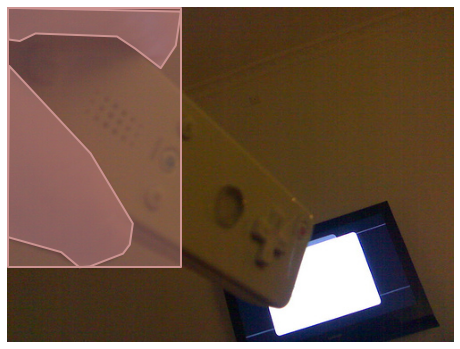

In [32]:
# load and display instance annotations for SELECTED categories
plt.imshow(sample_img); plt.axis('off')
annIds = coco.getAnnIds(imgIds=sample_img_info['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
print(len(anns), 'objects of selected categories found on this image.')

In [33]:
for ann in anns:
    for key in ann:
        print(key, '\n\t', ann[key])
        print()
    print('-'*115)

segmentation 
	 [[194.26, 2.96, 188.34, 42.65, 171.45, 67.99, 142.74, 46.03, 122.47, 32.52, 31.25, 29.14, 13.51, 37.58, 0.84, 35.9, 0.0, 0.42, 193.41, 4.65], [1.69, 65.46, 92.91, 163.43, 140.2, 241.98, 136.82, 265.63, 129.22, 275.76, 92.06, 290.12, 80.24, 290.96, 59.97, 274.07, 0.0, 257.18]]

area 
	 25114.825599999996

iscrowd 
	 0

image_id 
	 533145

bbox 
	 [0.0, 0.42, 194.26, 290.54]

category_id 
	 1

id 
	 204277

-------------------------------------------------------------------------------------------------------------------


3 objects of selected categories found on this image.


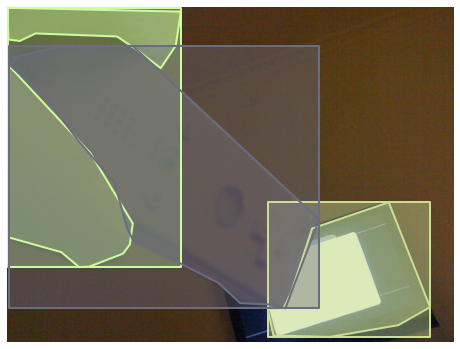

In [34]:
# load and display instance annotations for ALL categories
plt.imshow(sample_img); plt.axis('off')
annIds = coco.getAnnIds(imgIds=sample_img_info['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)
print(len(anns), 'objects of selected categories found on this image.')